# NOTEBOOK EDA

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import os
import re

import missingno as msno
import sys

from rapidfuzz import process, fuzz

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"C:\Users\victo\OneDrive\Escritorio\TFM-Sesgos-en-el-sistema-judicial-de-EEUU-\00_Data\00_Processed\df_final.csv")

In [3]:
def convert_to_datetime(df):
    date_regex = r'^(?:(?:\d{4}[-/]\d{1,2}[-/]\d{1,2})|(?:\d{1,2}[-/]\d{1,2}[-/]\d{2,4}))(?:[\sT]+(?:[01]?\d|2[0-3]):[0-5]\d(?::[0-5]\d)?)?$'

    for col in df.columns:
        if df[col].dtype.name == 'object':
            mask = df[col].dropna().str.match(date_regex)
            if mask.all():
                df[col] = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)

    return df

In [4]:
def convert_categorical(df):
    age_order = ['less than 25', '25 - 45', 'greater than 45']
    score_order = ['low', 'medium', 'high']
    charge_degree_order = ["misdemeanor", "felony"]


    df["age_cat"] = pd.Categorical(df["age_cat"], categories= age_order, ordered=True)
    df["score_text"] = pd.Categorical(df["score_text"], categories= score_order, ordered=True)
    df["c_charge_degree"] = pd.Categorical(df["c_charge_degree"], categories= charge_degree_order, ordered=True)


    return df

In [5]:
df.columns

Index(['name', 'sex', 'dob', 'age', 'age_cat', 'decile_score',
       'v_decile_score', 'is_recid', 'is_violent_recid', 'score_text',
       'screening_date', 'two_year_recid', 'priors_count', 'c_charge_degree',
       'person_id', 'agency_text', 'ethnic_code_text', 'maritalstatus',
       'language'],
      dtype='object')

In [6]:
df["score_text"].unique()

array(['low', 'medium', 'high'], dtype=object)

In [7]:
df = convert_to_datetime(df)

In [8]:
df = convert_categorical(df)

## Guión


### -Sacar gráficos
    - Estadísticos descriptivos de las variables
    - .corr de scores y demográficas
    - is_recid y is_v_recid con demográficas
    - cantidad de falsos positivos y falsos negativos + porcentaje de acierto del score
    - Tablas de contigencias de variables demográficas sobre is_recid y v_is_recid y score intervalos

In [63]:
# En bar plot (plotly), animation_frame para la barra interactuable
def eda(df):
    lista_variables_numericas = df.select_dtypes(include = "number").columns.tolist()
    lista_variables_numericas.remove("person_id")
    lista_variables_categoricas = df.select_dtypes(include = ["object", "category"]).columns.tolist()
    lista_variables_temporales = df.select_dtypes(include = "datetime").columns.tolist()
    print(lista_variables_categoricas)
    
    condicion_f = df["sex"] == "female"
    condicion_m = df["sex"] == "male"
    
    plt.pie(
        [df[condicion_f].shape[0], df[condicion_m].shape[0]],
        # explode=explode, 
        labels= [f'female  \n {df[condicion_f].shape[0]}', f'male \n {df[condicion_m].shape[0]}'], 
        # colors=colores, 
        autopct='%1.1f%%', # Muestra el porcentaje con un decimal
        # shadow=True, 
        # startangle=140)
    )
    plt.title('Distribucion por genero')
    plt.show()

    # df["ethnic_code_text"].value_counts().plot(kind="bar")
    # plt.title('Distribucion de personas por raza')
    # plt.show()

    counts = df["ethnic_code_text"].value_counts()
    total = counts.sum()

    df_count = counts.reset_index()
    df_count.columns = ["ethnic_code_text", "personas"]
    df_count["pct"] = df_count["personas"] / total

    fig = px.bar(
        df_count,
        x='ethnic_code_text',
        y='personas',
        text= df_count.apply(
        lambda r: f"{r['pct']:.1%}",
        axis=1
    ),
    )

    fig.update_layout(
        title='Número de personas por etnia',
        yaxis_title='Número de personas'
    )

    fig.show()

    
    print(f"Media:\n{df[lista_variables_numericas].mean()}")
    print("\n")
    print(f"Mediana:\n{df[lista_variables_numericas].median()}")
    print("\n")
    print(f"Mínimo:\n{df[lista_variables_numericas].min()}")
    print("\n")
    print(f"Máximo:\n{df[lista_variables_numericas].max()}")
    print("\n")

    for col in lista_variables_numericas:
        df[[col]].boxplot(figsize=(8,5))
        plt.title(f"Distribución general de {col}")
        plt.show()
        print("\n")

    for col in lista_variables_numericas:
        sns.boxplot(
            data= df,
            x="ethnic_code_text",
            y= col,
            hue="sex"
        )
        plt.title(f"Distribución de {col} por género y raza")
        plt.show()
        print("\n")

 
    # for var in lista_variables_numericas:
    #     sns.lineplot(
    #         data=df,
    #         x="Año",
    #         y=var,
    #         hue="sex",
    #         marker="o"
    #     )
    #     plt.title(f"Evolución temporal de {var}")
    #     plt.xticks(df["Año"].unique())
    #     plt.show()
    #     print("\n")



In [10]:
# df = df.set_index("person_id")

['name', 'sex', 'age_cat', 'score_text', 'c_charge_degree', 'agency_text', 'ethnic_code_text', 'maritalstatus', 'language']


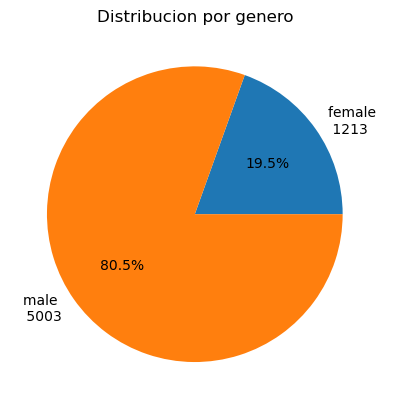

Media:
age                 35.269788
decile_score         4.335425
v_decile_score       3.584942
is_recid             0.397844
is_violent_recid     0.096203
two_year_recid       0.362452
priors_count         3.227477
dtype: float64


Mediana:
age                 32.0
decile_score         4.0
v_decile_score       3.0
is_recid             0.0
is_violent_recid     0.0
two_year_recid       0.0
priors_count         1.0
dtype: float64


Mínimo:
age                 19
decile_score         1
v_decile_score       1
is_recid             0
is_violent_recid     0
two_year_recid       0
priors_count         0
dtype: int64


Máximo:
age                 96
decile_score        10
v_decile_score      10
is_recid             1
is_violent_recid     1
two_year_recid       1
priors_count        37
dtype: int64




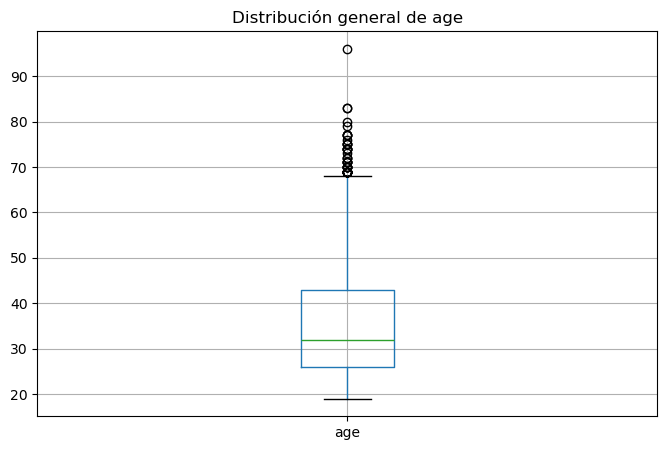

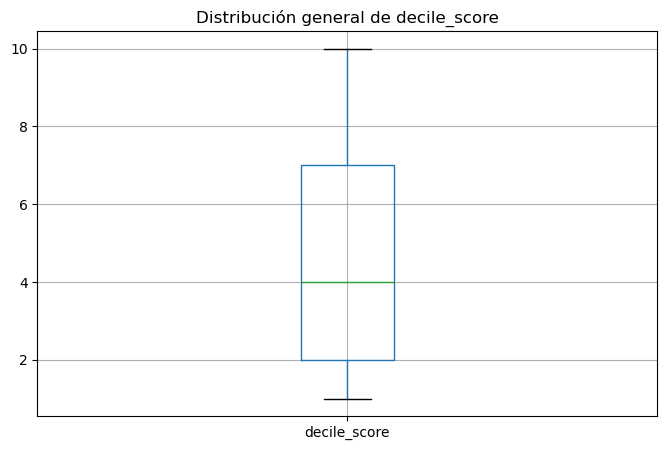

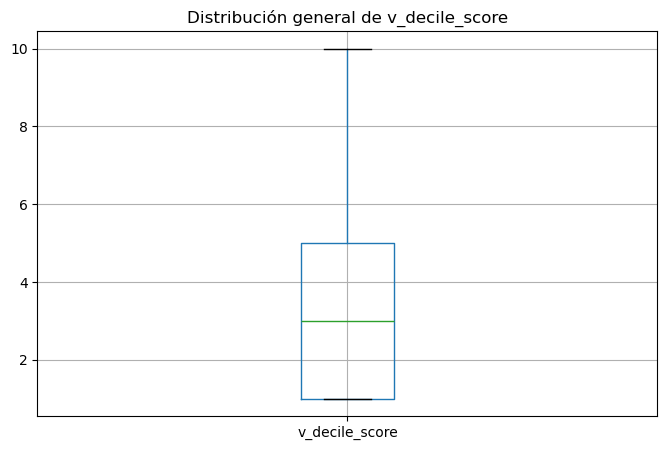

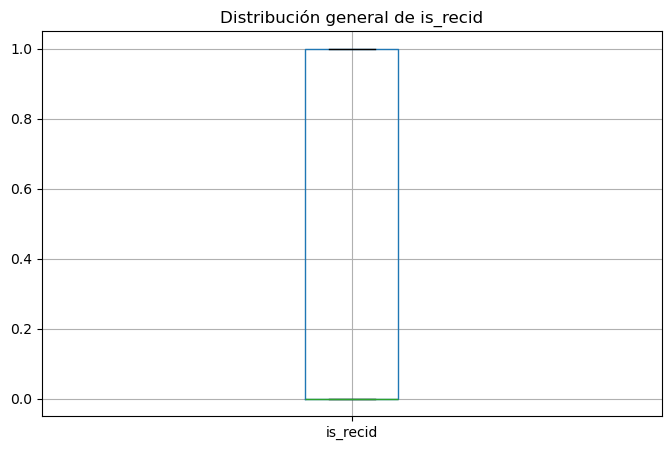

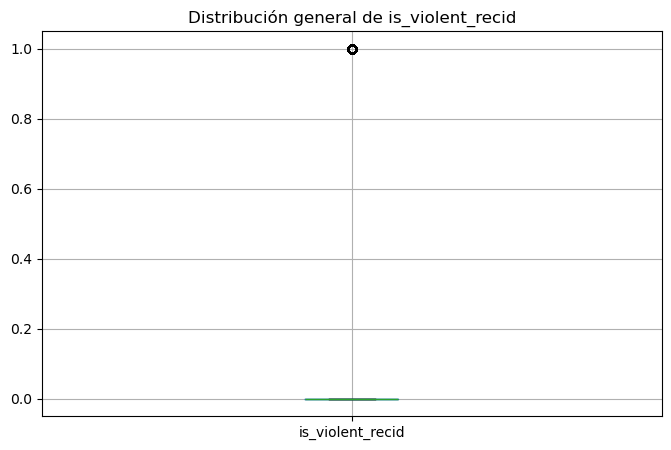

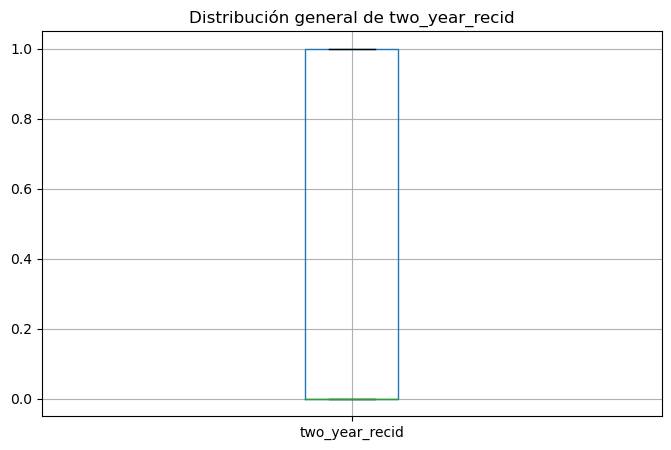

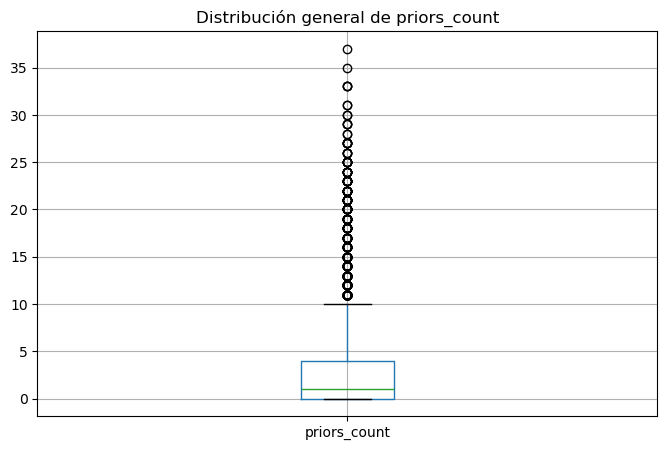

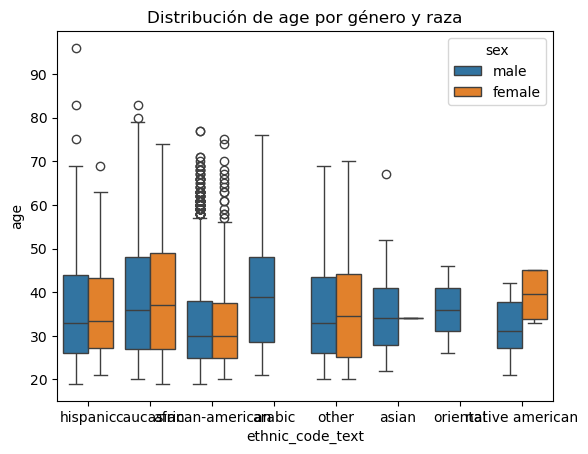

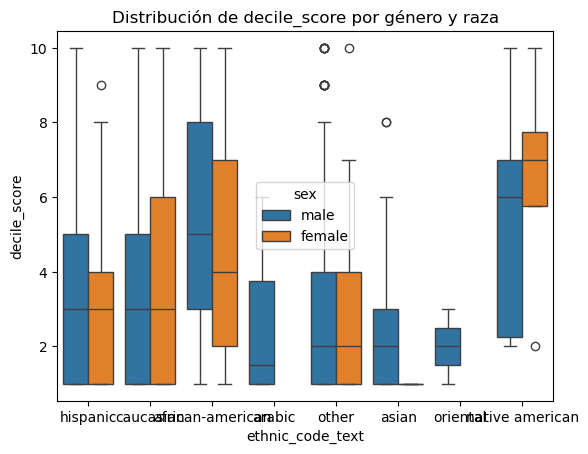

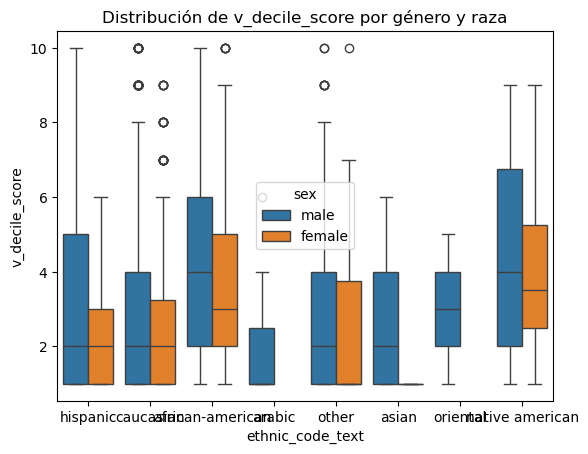

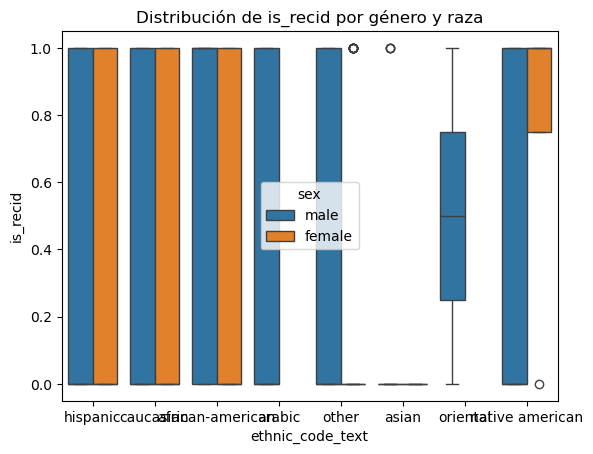

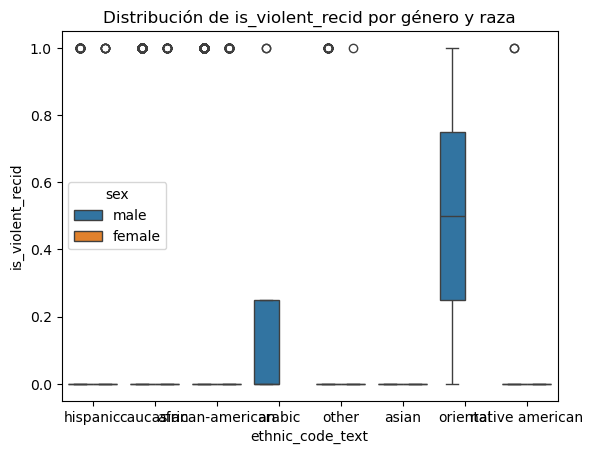

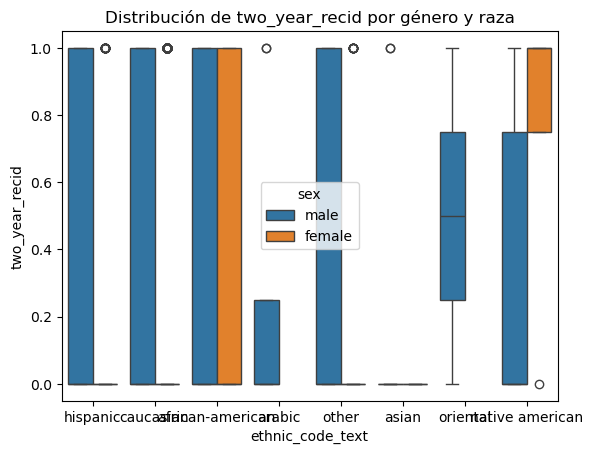

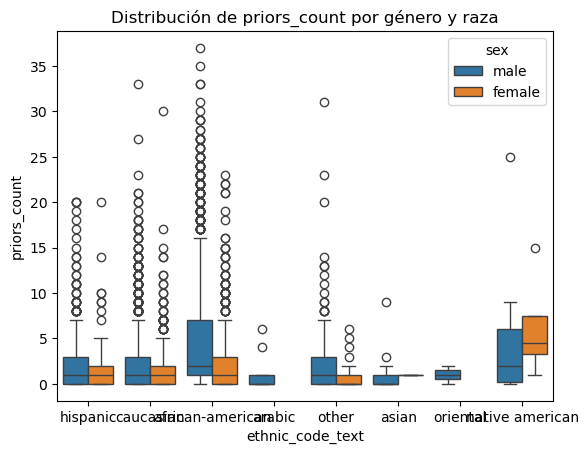

In [64]:
eda(df)

In [12]:
df["c_charge_degree"].unique()

['felony', 'misdemeanor']
Categories (2, object): ['misdemeanor' < 'felony']

In [46]:
df_count = (
        df['ethnic_code_text']
        .value_counts()
        .reset_index()
    )

In [47]:
df_count

,ethnic_code_text,count
0,african-american,3103
1,caucasian,2094
2,hispanic,565
3,other,333
4,asian,18
5,native american,14
6,arabic,8
7,oriental,2


In [ ]:
df